In [1]:
import cv2
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import skimage
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
import sqlite3
import xgboost as xgb
import colorsys
import shutil
from time import time
sys.path.append(os.environ['REPO_DIR'])
from lib.utils import configuration, run

In [2]:
def CDF(x):
    x=np.sort(x)
    size=x.shape[0]
    y=np.arange(0,size)/size
    return x,y


def setup_download_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if os.path.exists(local_fp):
        print('ALREADY DOWNLOADED FILE')
        return

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(s3_fp, local_fp))
    else:
        run('aws s3 cp {0} {1}'.format(s3_fp, local_fp))

def setup_upload_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(local_fp, s3_fp))
    else:
        run('aws s3 cp {0} {1}'.format(local_fp, s3_fp))

In [52]:
fp = os.environ['ROOT_DIR'] + 'CSHL_patch_samples_features_old/MD585/SC/'
! aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_patch_samples_features/MD585/SC/ $fp

download: s3://mousebrainatlas-data/CSHL_patch_samples_features/MD585/SC/MD585_SC_negative.pkl to ../../../../../../data/Shapeology_Files/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_samples_features_old/MD585/SC/MD585_SC_negative.pkl
download: s3://mousebrainatlas-data/CSHL_patch_samples_features/MD585/SC/MD585_SC_positive.pkl to ../../../../../../data/Shapeology_Files/BstemAtlasDataBackup/ucsd_brain/CSHL_patch_samples_features_old/MD585/SC/MD585_SC_positive.pkl


In [3]:
stack = 'MD594'
fp = os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt')
setup_download_from_s3(fp, recursive=False)
with open(os.environ['ROOT_DIR']+fp, 'r') as f:
    fn_idx_tuples = [line.strip().split() for line in f.readlines()]
    section_to_filename = {int(idx): fn for fn, idx in fn_idx_tuples}
    
fname = os.path.join('CSHL_data_processed', stack, 'Annotation.npy')
setup_download_from_s3(fname, recursive=False)
annotation = np.load(os.environ['ROOT_DIR']+fname, allow_pickle = True, encoding='latin1')
contours = pd.DataFrame(annotation)
contours = contours.rename(columns={0:"name", 1:"section", 2:"vertices"})
contours_grouped = contours.groupby('section')
contours_struc = contours.groupby('name')
valid_sections = np.sort(contours['section'].unique())

fn = 'CSHL_data_processed/MD589/ThresholdsV2.pkl'
setup_download_from_s3(fn, recursive=False)
thresholds = pickle.load(open(os.environ['ROOT_DIR']+fn,'rb'))

fn = 'CSHL_data_processed/MD594/holds.pkl'
setup_download_from_s3(fn, recursive=False)
holds = pickle.load(open(os.environ['ROOT_DIR']+fn,'rb'))

ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE


In [5]:
holds['SC']

{'rotation': [[20, 60], [-50, 10]]}

In [4]:
#Parameters
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.2      # shrinkage parameter
param['silent'] = 1     # not silent
param['objective'] = 'binary:logistic' #'multi:softmax'
param['nthread'] = 7 # Number of threads used
param['num_class']=1
num_round = 100

In [6]:
cell_dir = os.environ['ROOT_DIR'] + 'CSHL_patch_samples_features/MD589/'
cell2_dir = os.environ['ROOT_DIR'] + 'CSHL_patch_samples_features/MD585/'

In [7]:
resol = 0.46

paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures

In [8]:
section = 140+94+3
margin = 200/0.46

polygons = [(contour['name'], contour['vertices']) \
            for contour_id, contour in contours_grouped.get_group(section).iterrows()]

db_dir = 'CSHL_databases/' + stack + '/'
db_fp = db_dir + str(section) + '.db'
setup_download_from_s3(db_fp, recursive=False)
conn = sqlite3.connect(os.environ['ROOT_DIR']+ db_fp)
cur = conn.cursor()

run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_databases/MD594/237.db /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/237.db


In [9]:
raw_images_root = 'CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'
img_fn = raw_images_root + section_to_filename[section] + '_prep2_lossless_gray.tif'
setup_download_from_s3(img_fn, recursive=False)
img = cv2.imread(os.environ['ROOT_DIR']+img_fn, 2)
m, n = img.shape

run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_prep2_lossless_gray.tif /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_prep2_lossless_gray.tif


In [10]:
m,n

(11104, 17216)

In [11]:
origin= ['area', 'height', 'horiz_std', 'mean', 'padded_size',
       'rotation', 'rotation_confidence', 'std', 'vert_std', 'width', 'density', 'area_ratio']
columns = []
for i in range(10):
    name = 'DMVec'+str(i)
    for j in range(99):
        columns.append(name+'*'+str(j))
for i in range(10):
    name = origin[i]
    for j in range(99):
        columns.append(name+'*'+str(j))
columns.extend(origin[-2:])
columns = np.array(columns)

In [12]:
thresh = cv2.adaptiveThreshold(255 - img, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, -20)
Stats = cv2.connectedComponentsWithStats(thresh)
mask = Stats[1]

In [13]:
%%time
importances = {}
sort_by_imp = {}
for contour_id, contour in polygons:
    structure = contour_id
    if structure != 'SC':
        continue
    polygon = contour.copy()

    if structure == '7n':
        structure = '7nn'

    fp = []
    fp.append(cell_dir + structure + '/MD589_' + structure + '_positive.pkl')
    fp.append(cell_dir + structure + '/MD589_' + structure + '_negative.pkl')
    X_train = []
    y_train = []
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1 - state] * len(clouds))

    fp = []
    fp.append(cell2_dir + structure + '/MD585_' + structure + '_positive.pkl')
    fp.append(cell2_dir + structure + '/MD585_' + structure + '_negative.pkl')
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1 - state] * len(clouds))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=columns)
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

    if structure == '7nn':
        structure = '7n'

    gains = bst.get_score(importance_type='total_gain')
    importances[structure] = {}
    for feature in gains.keys():
        if feature == 'density' or feature == 'area_ratio':
            importances[structure][feature] = gains[feature]
        else:
            star = feature.rfind('*')
            name = feature[:star]
            if name not in importances[structure].keys():
                importances[structure][name] = {}
            importances[structure][name][feature] = gains[feature]
    features = importances[structure].keys()
    scores = {}
    for feature in features:
        if feature == 'density' or feature == 'area_ratio':
            scores[feature] = importances[structure][feature]
        else:
            total = np.array(
                [importances[structure][feature][name] for name in importances[structure][feature].keys()]).sum()
            scores[feature] = total
    features_sorted = sorted(scores, key=scores.__getitem__, reverse=True)
    sort_by_imp[structure] = features_sorted[:5]

CPU times: user 32.5 s, sys: 807 ms, total: 33.3 s
Wall time: 13.3 s


In [14]:
sort_by_imp

{'SC': ['rotation', 'area_ratio', 'density', 'DMVec8', 'vert_std']}

In [15]:
window_size = 224
stride = 56
color_mark = [0.68, 0.02, 0.33, 0.75, 0.22]

In [19]:
%%time
from skimage import color
whole = color.gray2rgb(img)
hsv = np.zeros([m, n, 3])
hsv[:, :, 2] = img.copy()/255
bboxs = []
pops = []
cs = []

for contour_id, contour in polygons:
    structure = contour_id
    if structure != 'SC':
        continue
    polygon = contour.copy()

    if structure == '7n':
        structure = '7nn'

    fp = []
    fp.append(cell_dir + structure + '/MD589_' + structure + '_positive.pkl')
    fp.append(cell_dir + structure + '/MD589_' + structure + '_negative.pkl')
    X_train = []
    y_train = []
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1 - state] * len(clouds))

    fp = []
    fp.append(cell2_dir + structure + '/MD585_' + structure + '_positive.pkl')
    fp.append(cell2_dir + structure + '/MD585_' + structure + '_negative.pkl')
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1 - state] * len(clouds))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

    if structure == '7nn':
        structure = '7n'

    [left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 0]) + margin), n)),
                               int(max(min(polygon[:, 1]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 1]) + margin), m))]
    bboxs.append([left, right, up, down])
    cs.append(polygon.astype(np.int32))
    raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?', (left, right, up, down))
    info = np.array(list(raws))
    locations = info[:, 1:3]
    features = info[:, 3:]

    xs, ys = np.meshgrid(np.arange(left, right, stride), np.arange(up, down, stride), indexing='xy')
    windows = np.c_[xs.flat, ys.flat]
    
    for index in range(len(windows)):
        extracted = []
        wx = int(windows[index][0])
        wy = int(windows[index][1])
        indices_window = np.where((locations[:, 0] > wx) & (locations[:, 0] < wx + window_size) \
                                  & (locations[:, 1] > wy) & (locations[:, 1] < wy + window_size))[0]
        if len(indices_window):
            cells = features[indices_window]
            for k in range(cells.shape[1]):
                x, y = CDF(cells[:, k])
                ten = [y[np.argmin(np.absolute(x - thresholds[k][j]))] for j in range(99)]
                extracted.extend(ten)
            extracted.extend([cells.shape[0]])
            extracted.extend([cells[:, 10].sum() / (224 * 224)])
        else:
            extracted.append([0] * 1982)
        xtest = xgb.DMatrix(extracted)
        score = bst.predict(xtest, output_margin=True, ntree_limit=bst.best_ntree_limit)
        origin = hsv[wy: wy + window_size, wx: wx + window_size, 1]
        satua_img = np.zeros_like(origin) + score
        comp = np.absolute(origin) - np.absolute(satua_img)
        hsv[wy: wy + window_size, wx: wx + window_size, 1] = origin * (comp > 0) + satua_img * (comp < 0)
    hsv[up:down, left:right, 0] = (hsv[up:down, left:right, 1] < 0) * 0.66 + \
                                (hsv[up:down, left:right, 1] > 0) * 1
    hsv[up:down, left:right, 1] = np.absolute(hsv[up:down, left:right, 1])
    hsv[up:down, left:right, 1] = (hsv[up:down, left:right, 1] - hsv[up:down, left:right, 1].min()) \
                              / (hsv[up:down, left:right, 1].max() - hsv[up:down, left:right, 1].min()) * 0.3

    k = 0
    pop = []
    color = colorsys.hsv_to_rgb(0.66, 0.8, 1)
    reach = structure
    pop.append([color, reach])
    mix_state = 0
    features_sorted = sort_by_imp[structure]
    for feature in features_sorted[:3]:
        if feature != 'density' and feature != 'area_ratio':
            name = list(importances[structure][feature].keys())[0]
            index = np.where(columns == name)[0][0]
            raw = index // 99
            for i in range(len(holds[structure][feature])):
                min_value = holds[structure][feature][i][0]
                max_value = holds[structure][feature][i][1]
                posi = np.where((features[:, raw] > min_value) & (features[:, raw] < max_value))[0]
                for cell in posi:
                    height = int(features[cell, 11])
                    width = int(features[cell, 19])
                    cx = int(locations[cell, 0] - width / 2.0)
                    cy = int(locations[cell, 1] - height / 2.0)
                    try:
                        objects = np.unique(mask[cy:cy + height, cx:cx + width])[1:]
                        counts = [(mask[cy:cy + height, cx:cx + width]==object_id).sum() for object_id in objects]
                        object_id = objects[np.argmax(np.array(counts))]
                    except:
                        continue

                    colors = np.unique(hsv[cy:cy + height, cx:cx + width, 0]*(mask[cy:cy + height, cx:cx + width] == object_id))
                    if len(colors) == 1:
                        hsv[cy:cy + height, cx:cx + width, 0] = color_mark[k] * (
                                    mask[cy:cy + height, cx:cx + width] == object_id) + \
                                                                hsv[cy:cy + height, cx:cx + width, 0] * (
                                                                            mask[cy:cy + height, cx:cx + width] != object_id)
                        hsv[cy:cy + height, cx:cx + width, 1] = 0.85 * (mask[cy:cy + height, cx:cx + width] == object_id) + \
                                                                hsv[cy:cy + height, cx:cx + width, 1] * (
                                                                            mask[cy:cy + height, cx:cx + width] != object_id)
#                         hsv[cy:cy + height, cx:cx + width, 2] = (mask[cy:cy + height, cx:cx + width]== object_id) + \
#                                                                 hsv[cy:cy + height, cx:cx + width, 2] * (
#                                                                             mask[cy:cy + height, cx:cx + width] != object_id)
                    else:
                        label = np.array([0.0, 0.66, 1.0])
                        colors = np.setdiff1d(colors, label)
                        if len(colors)<2:
                            cols = int(width / (len(colors) + 1))
                            pattern = np.ones([1, width]) * color_mark[k]
                            pattern[0, :cols * len(colors)] = np.repeat(colors, cols)
                            pattern = np.ones([height, width]) * pattern
                        else:
                            pattern = color_mark[-1]
                            mix_state = 1
                        pattern = pattern * (mask[cy:cy + height, cx:cx + width] == object_id) + \
                                  hsv[cy:cy + height, cx:cx + width, 0] * (mask[cy:cy + height, cx:cx + width] != object_id)
                        hsv[cy:cy + height, cx:cx + width, 0] = pattern
                        hsv[cy:cy + height, cx:cx + width, 1] = 0.85 * (mask[cy:cy + height, cx:cx + width] == object_id) + \
                                                                hsv[cy:cy + height, cx:cx + width, 1] * (
                                                                            mask[cy:cy + height, cx:cx + width] != object_id)
#                         hsv[cy:cy + height, cx:cx + width, 2] = (mask[cy:cy + height, cx:cx + width]== object_id) + \
#                                                                 hsv[cy:cy + height, cx:cx + width, 2] * (
#                                                                             mask[cy:cy + height, cx:cx + width] != object_id)
                reach = feature + ' (%.1f, %.1f)' % (min_value, max_value)
                color = colorsys.hsv_to_rgb(color_mark[k], 0.8, 1)
                pop.append([color, reach])
                k += 1
                # if k==4:
                #     break
        else:
            reach = feature
            color = colorsys.hsv_to_rgb(color_mark[k], 0.8, 1)
            pop.append([color, reach])
            k += 1
        # if k==4:
        #     break
    if mix_state:
        color = colorsys.hsv_to_rgb(color_mark[-1], 0.8, 1)
        reach = 'mix'
        pop.append([color, reach])
    pops.append(pop)

for i in range(len(bboxs)):
    left, right, up, down = bboxs[i]
    rgb = skimage.color.hsv2rgb(hsv[up:down, left:right, :])
    rgb = rgb * 255
    rgb = rgb.astype(np.uint8)
    polygon = cs[i]
    polygon[:, 0] = polygon[:, 0] - left
    polygon[:, 1] = polygon[:, 1] - up
    com = cv2.polylines(rgb.copy(), [polygon.astype(np.int32)], True, [0, 255, 255], 3, lineType=250)
#     com = cv2.GaussianBlur(rgb, (5,5), 0)
    whole[up:down, left:right] = rgb.copy()
    


CPU times: user 1min 48s, sys: 22.9 s, total: 2min 11s
Wall time: 3min 34s


CPU times: user 634 ms, sys: 109 ms, total: 742 ms
Wall time: 752 ms


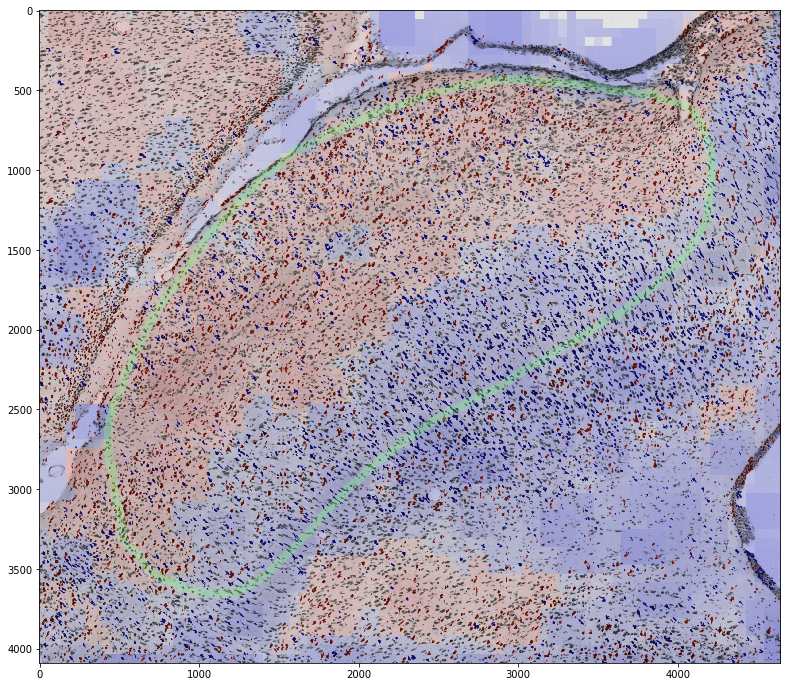

In [32]:
%%time
area = (right - left) * (down - up)
thickness = int(min(right - left, down - up)/80)
com = cv2.GaussianBlur(rgb.copy(), (5, 5), 0)
final = com.copy()
com = cv2.polylines(com, [polygon.astype(np.int32)], True, [127, 255, 127], thickness, lineType=8)
cv2.addWeighted(com, 0.3, final, 0.7, 0, final)
whole[up:down, left:right] = final.copy()
plt.figure(figsize=(15,12))
plt.imshow(whole[up:down, left:right,:])

In [35]:
from skimage import io
io.imsave('/Users/kuiqian/Downloads/Visual_feedback_local.jpg',whole[up:down, left:right,:])

In [37]:
from skimage.transform import rescale
rgb8 = rescale(whole, 1.0/8, multichannel=True, anti_aliasing=True)
rgb8 = rgb8 * 255
rgb8 = rgb8.astype(np.uint8)
io.imsave('/Users/kuiqian/Downloads/Visual_feedback_overview.jpg',rgb8)

In [25]:
bboxs

[[2778, 4761, 2524, 4612]]

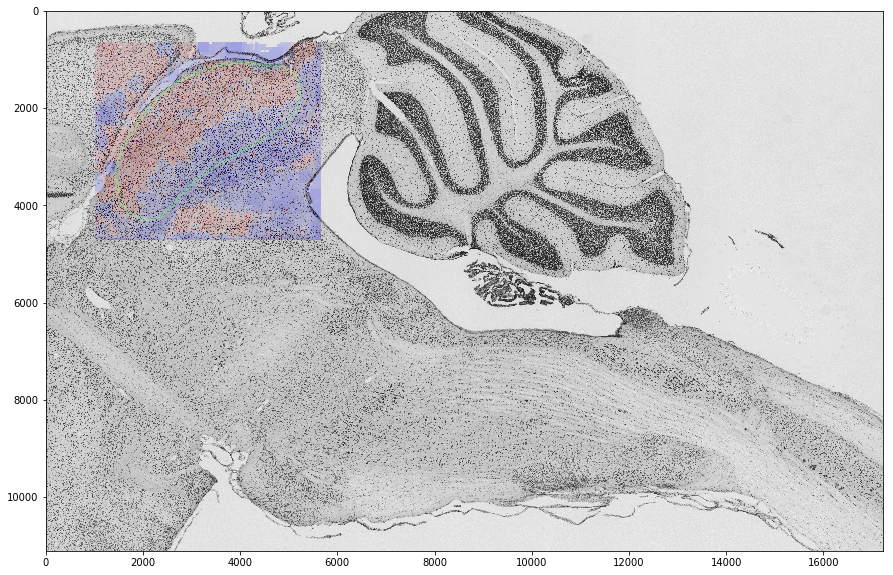

In [33]:
plt.figure(figsize=(15,12))
plt.imshow(whole)

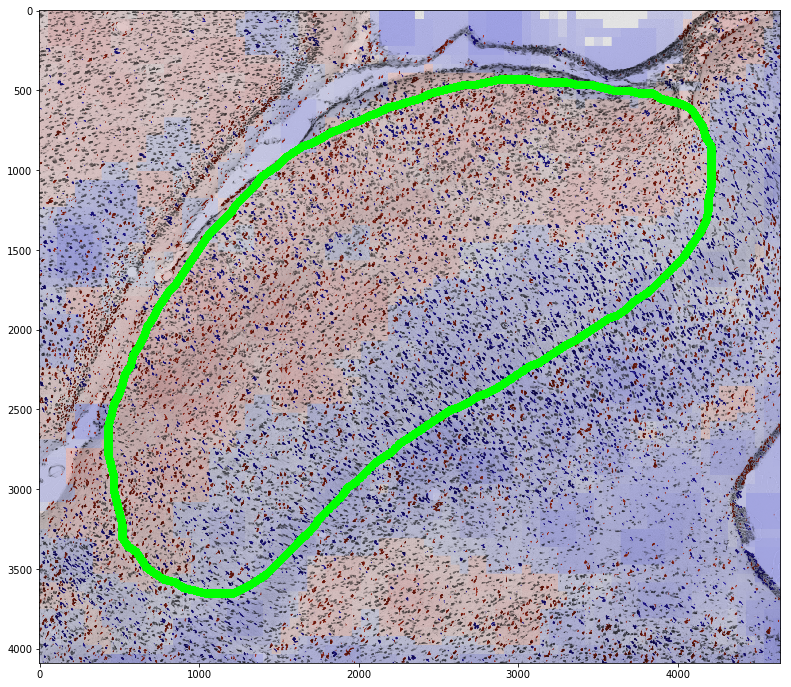

In [24]:
plt.figure(figsize=(15,12))
plt.imshow(whole[up:down, left:right,:])